# PREDICTION DE LA VARIABLE EMISSION CO2

# SOMMAIRE
## [IMPORT DES LIBRAIRIES](#1)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#2)<a class="anchor" id="sommaire"></a>
## [1. STANDARDISATION DES DONNEES](#3)<a class="anchor" id="sommaire"></a>
## [2. MODELISATION SANS ENERGYSTARSCORE](#4)<a class="anchor" id="sommaire"></a>
### [a. ElasticNet](#5)<a class="anchor" id="sommaire"></a>
### [b. XGBoost](#6)<a class="anchor" id="sommaire"></a>
## [3. MODELISATION AVEC ENERGYSTARSCORE](#7)<a class="anchor" id="sommaire"></a>
### [a. ElasticNet](#8)<a class="anchor" id="sommaire"></a>
### [b. XGBoost](#9)<a class="anchor" id="sommaire"></a>
## [CONCLUSION](#10)<a class="anchor" id="sommaire"></a>

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import tabula as tb
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer, MaxAbsScaler , OneHotEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn , KNeighborsRegressor as knr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.utils.fixes import loguniform
from functions import *
from math import radians
import json
import timeit
from timeit import default_timer as timer
import datetime as dt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import plotly.graph_objects as go
import shap

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="2"></a>

In [2]:
raw_data = pd.read_csv("DATA/clean_data.csv", index_col = 0)
raw_data = raw_data.reset_index(drop=True)

In [3]:
gas_pred = pd.read_csv("DATA/Predictions/naturalgas_pred.csv")
elec_pred = pd.read_csv("DATA/Predictions/elec_pred.csv")
other_pred = pd.read_csv("DATA/Predictions/other_pred.csv")
steam_pred = pd.read_csv("DATA/Predictions/steam_pred.csv")
energy_pred = pd.read_csv("DATA/Predictions/energyuse_pred.csv")

In [4]:
other_pred.shape

(3167, 2)

In [5]:
raw_data = pd.concat([raw_data, gas_pred, elec_pred, other_pred, steam_pred, energy_pred], axis = 1)

In [6]:
raw_data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'NumberofBuildings', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUse_kBtu',
       'SteamUse_kBtu', 'Electricity_kBtu', 'NaturalGas_kBtu',
       'OtherFuelUse_kBtu', 'GHGEmissions_MetricTonsCO2e',
       'GHGEmissionsIntensity_kgCO2e_ft2', 'Unnamed: 0', 'NaturalGas_pred',
       'Unnamed: 0', 'Elec_pred', 'Unnamed: 0', 'Other_pred', 'Unnamed: 0',
       'Steam_pred', 'Unnamed: 0', 'EnergyUse_pred'],
      dtype='object')

In [7]:
raw_data = raw_data.drop('Unnamed: 0', axis =1)

In [8]:
df_analyse = raw_data.loc[:, ['GHGEmissions_MetricTonsCO2e', 'NaturalGas_pred', 'Elec_pred',
       'Other_pred', 'Steam_pred', 'EnergyUse_pred']]

In [9]:
df_analyse.columns

Index(['GHGEmissions_MetricTonsCO2e', 'NaturalGas_pred', 'Elec_pred',
       'Other_pred', 'Steam_pred', 'EnergyUse_pred'],
      dtype='object')

## [1. STANDARDISATION DES DONNEES](#sommaire)<a class="anchor" id="3"></a>

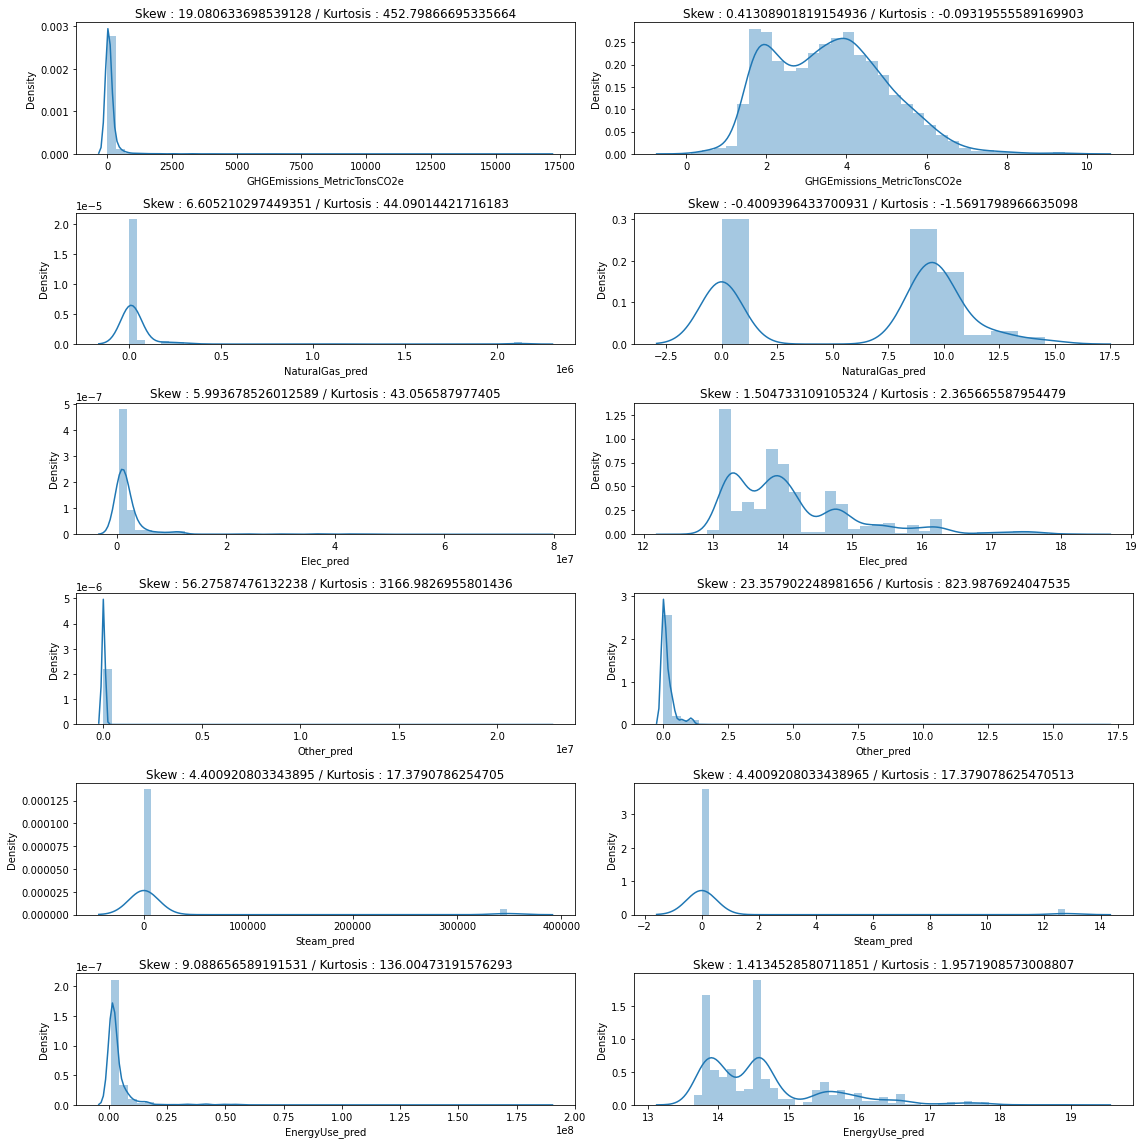

In [11]:
choices = data.columns



f, axs = plt.subplots(6,2, figsize = (16, 16))

i=0
choices[i]

for ix,iy in np.ndindex(axs.shape):
    if i == len(choices) :
        break
    else:
        if iy / 2 == 0 :
            k = df_analyse[choices[i]].kurtosis()
            sk = df_analyse[choices[i]].skew()
            ax1 = sns.distplot(df_analyse[choices[i]],ax=axs[ix,iy])
            ax1.set_title("Skew : " + str(sk) + " / Kurtosis : " + str(k))

        else :
            
            k = np.log(df_analyse[choices[i]]+1).kurtosis()
            sk = np.log(df_analyse[choices[i]]+1).skew()
            ax1 = sns.distplot(np.log(df_analyse[choices[i]]+1),ax=axs[ix,iy])
            ax1.set_title("Skew : " + str(sk) + " / Kurtosis : " + str(k))
            
            i+=1
            



plt.tight_layout()

In [12]:
y = np.log(df_analyse['GHGEmissions_MetricTonsCO2e']+1)
features = df_analyse.drop(['GHGEmissions_MetricTonsCO2e'],axis = 1)
features = np.log(features+1)
features_name = features.columns

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, random_state = 42)

In [14]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [15]:
X_test_t = pd.DataFrame(X_test, columns = features_name)
X_train_t = pd.DataFrame(X_train, columns = features_name)

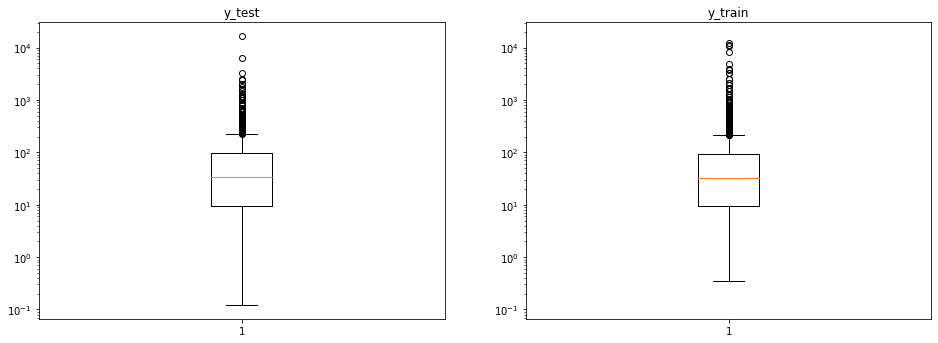

In [16]:
a = [(np.exp(scaler_y.inverse_transform(y_test))-1).reshape(1,-1).tolist(), (np.exp(scaler_y.inverse_transform(y_train))-1).reshape(1,-1).tolist()]

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)

ax1.boxplot(a[0], meanline = True)
ax1.set_title('y_test')
ax2.boxplot(a[1], meanline = True)
ax2.set_title('y_train')
ax1.set(yscale="log")
ax2.set(yscale="log")
plt.show()

In [17]:
print('Mean y_test : ', round(scaler_y.inverse_transform(y_test).mean(),3))
print('Mean y_train : ', round(scaler_y.inverse_transform(y_train).mean(), 3))

Mean y_test :  3.589
Mean y_train :  3.563


In [18]:
X_train.shape

(2121, 5)

## [2. MODELISATION SANS ENERGYSTARSCORE](#sommaire)<a class="anchor" id="3"></a>

### [a. ElasticNet](#sommaire)<a class="anchor" id="4"></a>

In [19]:
random_grid = {'alpha': np.logspace(-5, 1, 60),
               'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
               'selection':['cyclic', 'random']}

In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
eln = ElasticNet(fit_intercept=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
eln_random = RandomizedSearchCV(estimator = eln, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
start = timer()
eln_random.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The time of execution of above program is :  0:00:01.300591


In [21]:
ElasticNet().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [22]:
eln_random.best_params_

{'selection': 'random', 'l1_ratio': 0.95, 'alpha': 0.014208308325339224}

In [23]:
eln_random.best_score_

0.5229311713467434

In [24]:
best_random = eln_random.best_estimator_
random_accuracy_test = eln_random.score(X_test, y_test)
random_accuracy_train = eln_random.score(X_train, y_train)

In [25]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.5251871094708858
Score test : 0.5132053479291412


In [26]:
# Make predictions and determine the error
predictions = np.exp(scaler_y.inverse_transform(eln_random.predict(X_train))-1)
errors = abs(np.exp(scaler_y.inverse_transform(y_train)-1) - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((np.exp(scaler_y.inverse_transform(y_train)-1) - predictions) / np.exp(scaler_y.inverse_transform(y_train)-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_train)-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_train)-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = np.exp(scaler_y.inverse_transform(eln_random.predict(X_test))-1)
errors = abs(np.exp(scaler_y.inverse_transform(y_test)-1) - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((np.exp(scaler_y.inverse_transform(y_test)-1)- predictions) / np.exp(scaler_y.inverse_transform(y_test)-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_test)-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_test)-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

-- Train score --
Mean Absolute Deviation: 51.71
MAPE: 4.36 %.
MSE :  15981.49
RMSE :  126.42
Accuracy: 95.64 %.
-- Test score --
Mean Absolute Deviation: 57.62
MAPE: 5.03 %.
MSE :  42162.54
RMSE :  205.34
Accuracy: 94.97 %.


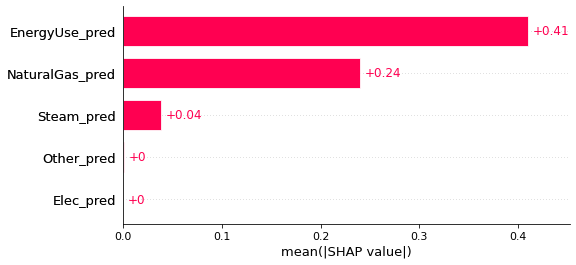

In [27]:
explainer = shap.Explainer(eln_random.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

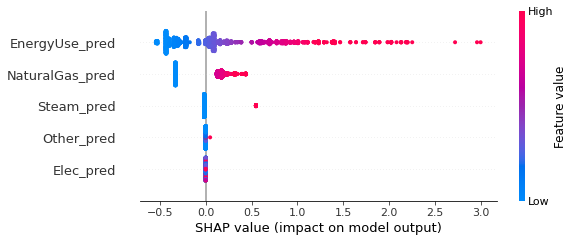

In [28]:
shap.summary_plot(shap_values, feature_names=features_name)

In [29]:
eln_df = pd.DataFrame(data = predictions)
eln_df['True_values'] = y_test
eln_df.columns = ['predictions', 'True_values']
eln_df['Residus'] = eln_df['predictions'] - eln_df['True_values']

In [30]:
eln_df = eln_df.sort_values('predictions')
eln_df = eln_df.reset_index(drop=True)

No handles with labels found to put in legend.


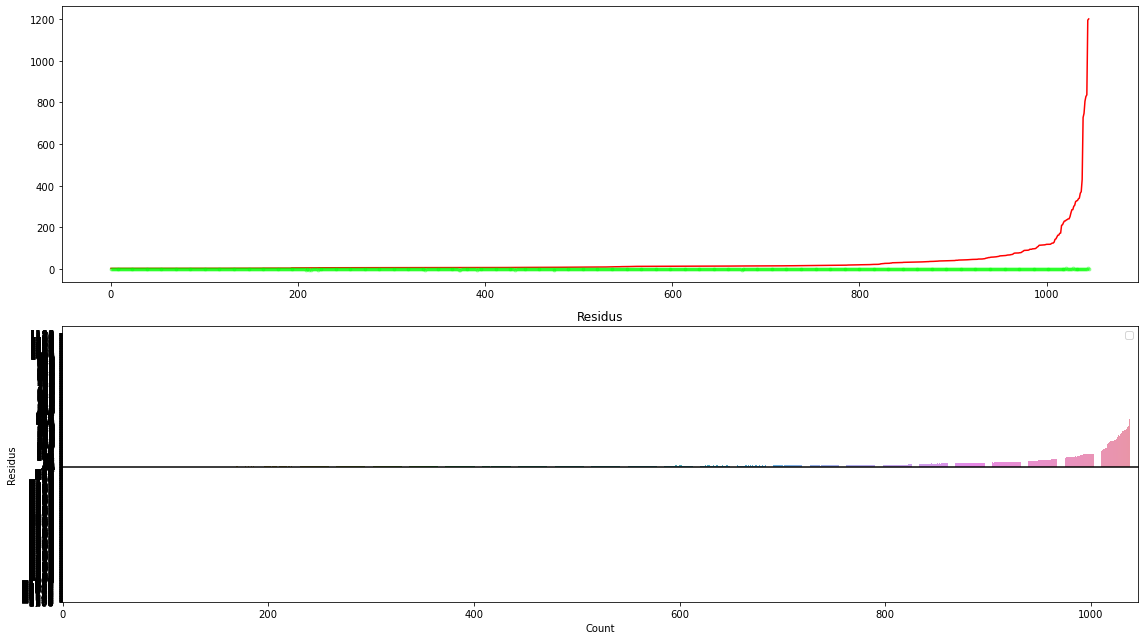

In [31]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(eln_df.index.to_list(), eln_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(eln_df.index.to_list(), eln_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=eln_df.index.to_list(), y=eln_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(eln_df.index.to_list()), max(eln_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(eln_df['Residus']),0)-1, round(max(eln_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

### [b. XGBoost](#sommaire)<a class="anchor" id="5"></a>

In [32]:
xgb1 = XGBRegressor(booster = 'gbtree')
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,.02,.03, 0.05, .07], #so called `eta` value
              'max_depth': [2,3,4,5],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [400]}

xgb_grid = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        verbose=2,
                        n_iter = 200,
                        n_jobs = -1)

In [33]:
start = timer()
xgb_grid.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
The time of execution of above program is :  0:00:19.809257


In [34]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.5568040678002583
{'subsample': 0.7, 'objective': 'reg:squarederror', 'nthread': 4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.7}


In [35]:
best_random = xgb_grid.best_estimator_
random_accuracy_test = xgb_grid.score(X_test, y_test)
random_accuracy_train = xgb_grid.score(X_train, y_train)

In [36]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.6030875026217004
Score test : 0.5445306127810599


In [37]:
# Make predictions and determine the error

predictions = (np.exp(scaler_y.inverse_transform(xgb_grid.predict(X_train)))-1)
errors = abs((np.exp(scaler_y.inverse_transform(y_train))-1) - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs(((np.exp(scaler_y.inverse_transform(y_train))-1) - predictions) / (np.exp(scaler_y.inverse_transform(y_train))-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_train))-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_train))-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = (np.exp(scaler_y.inverse_transform(xgb_grid.predict(X_test)))-1)
errors = abs((np.exp(scaler_y.inverse_transform(y_test))-1) - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs(((np.exp(scaler_y.inverse_transform(y_test))-1) - predictions) / (np.exp(scaler_y.inverse_transform(y_test))-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_test))-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_test))-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

-- Train score --
Mean Absolute Deviation: 143.9
MAPE: 5.73 %.
MSE :  80547.18
RMSE :  283.81
Accuracy: 94.27 %.
-- Test score --
Mean Absolute Deviation: 156.07
MAPE: 6.66 %.
MSE :  336669.18
RMSE :  580.23
Accuracy: 93.34 %.


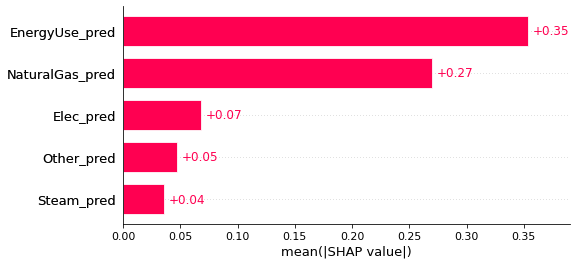

In [38]:
explainer = shap.TreeExplainer(xgb_grid.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

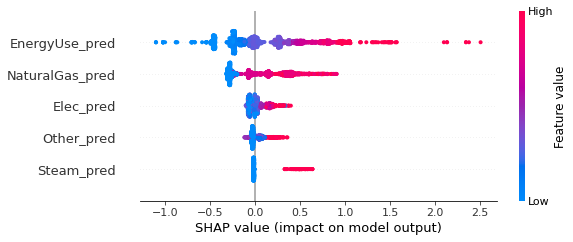

In [39]:
shap.summary_plot(shap_values, feature_names=features_name)

In [40]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(features_name, round(importance, 2)) for features_name, importance in zip(features_name, importances)]
# Sort the feature importances by most important firstperf_model['XGBoost Regressor'] = mape
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EnergyUse_pred       Importance: 0.3799999952316284
Variable: NaturalGas_pred      Importance: 0.2199999988079071
Variable: Elec_pred            Importance: 0.17000000178813934
Variable: Other_pred           Importance: 0.12999999523162842
Variable: Steam_pred           Importance: 0.10000000149011612


In [41]:
xgb_df = pd.DataFrame(data = (scaler_y.inverse_transform(xgb_grid.predict(X_test))))
xgb_df['True_values'] = (scaler_y.inverse_transform(y_test))
xgb_df.columns = ['predictions', 'True_values']
xgb_df['Residus'] = xgb_df['predictions'] - xgb_df['True_values']

In [42]:
xgb_df = xgb_df.sort_values('predictions')
xgb_df = xgb_df.reset_index(drop=True)

No handles with labels found to put in legend.


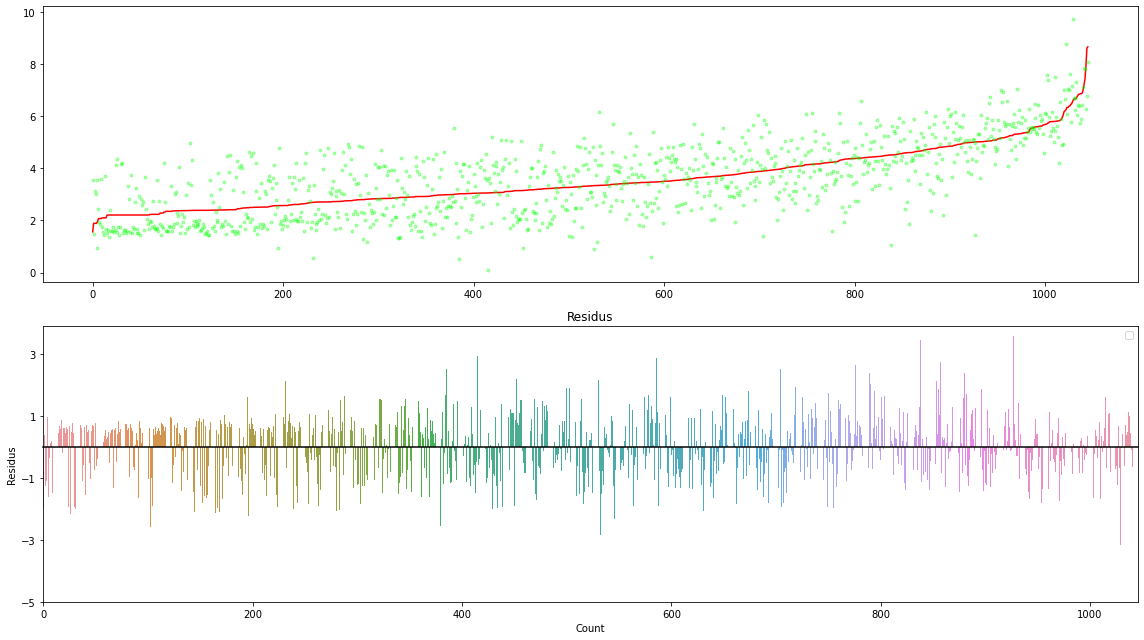

In [43]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(xgb_df.index.to_list(), xgb_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(xgb_df.index.to_list(), xgb_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=xgb_df.index.to_list(), y=xgb_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(xgb_df.index.to_list()), max(xgb_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(xgb_df['Residus']),0)-1, round(max(xgb_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

## [3. MODELISATION SANS ENERGYSTARSCORE](#sommaire)<a class="anchor" id="6"></a>

### [a. ElasticNet](#sommaire)<a class="anchor" id="7"></a>

In [44]:
df_analyse = raw_data.loc[:, ['GHGEmissions_MetricTonsCO2e', 'NaturalGas_pred', 'Elec_pred',
       'Other_pred', 'Steam_pred', 'EnergyUse_pred', 'ENERGYSTARScore']]

In [45]:
df_analyse = df_analyse.dropna(subset=['ENERGYSTARScore'])

In [46]:
y = np.log(df_analyse['GHGEmissions_MetricTonsCO2e']+1)
features = df_analyse.drop(['GHGEmissions_MetricTonsCO2e'],axis = 1)
features = np.log(features+1)
features_name = features.columns

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, random_state = 42)

In [48]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [49]:
X_test_t = pd.DataFrame(X_test, columns = features_name)
X_train_t = pd.DataFrame(X_train, columns = features_name)

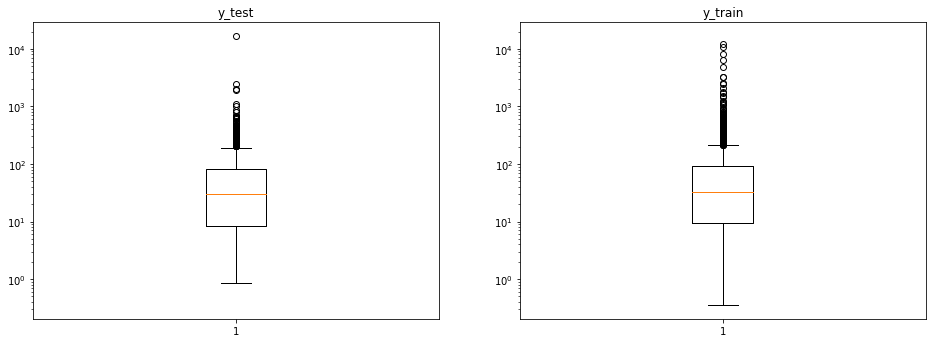

In [50]:
a = [(np.exp(scaler_y.inverse_transform(y_test))-1).reshape(1,-1).tolist(), (np.exp(scaler_y.inverse_transform(y_train))-1).reshape(1,-1).tolist()]

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)

ax1.boxplot(a[0], meanline = True)
ax1.set_title('y_test')
ax2.boxplot(a[1], meanline = True)
ax2.set_title('y_train')
ax1.set(yscale="log")
ax2.set(yscale="log")
plt.show()

In [51]:
print('Mean y_test : ', round(scaler_y.inverse_transform(y_test).mean(),3))
print('Mean y_train : ', round(scaler_y.inverse_transform(y_train).mean(), 3))

Mean y_test :  3.497
Mean y_train :  3.553


In [52]:
X_train.shape

(1589, 6)

In [53]:
X_test_t = pd.DataFrame(X_test, columns = features_name)
X_train_t = pd.DataFrame(X_train, columns = features_name)

In [54]:
random_grid = {'alpha': np.logspace(-5, 1, 60),
               'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
               'selection':['cyclic', 'random']}

In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
eln = ElasticNet(fit_intercept=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
eln_random = RandomizedSearchCV(estimator = eln, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
start = timer()
eln_random.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The time of execution of above program is :  0:00:00.461798


In [56]:
ElasticNet().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [57]:
eln_random.best_params_

{'selection': 'random', 'l1_ratio': 0.99, 'alpha': 0.008895134973108237}

In [58]:
eln_random.best_score_

0.5830782340592375

In [59]:
best_random = eln_random.best_estimator_
random_accuracy_test = eln_random.score(X_test, y_test)
random_accuracy_train = eln_random.score(X_train, y_train)

In [60]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.5883710632145056
Score test : 0.5558273997208311


In [61]:
# Make predictions and determine the error
predictions = np.exp(scaler_y.inverse_transform(eln_random.predict(X_train))-1)
errors = abs(np.exp(scaler_y.inverse_transform(y_train)-1) - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((np.exp(scaler_y.inverse_transform(y_train)-1) - predictions) / np.exp(scaler_y.inverse_transform(y_train)-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_train)-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_train)-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = np.exp(scaler_y.inverse_transform(eln_random.predict(X_test))-1)
errors = abs(np.exp(scaler_y.inverse_transform(y_test)-1) - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((np.exp(scaler_y.inverse_transform(y_test)-1)- predictions) / np.exp(scaler_y.inverse_transform(y_test)-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_test)-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(np.exp(scaler_y.inverse_transform(y_test)-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

-- Train score --
Mean Absolute Deviation: 55.13
MAPE: 4.86 %.
MSE :  14181.58
RMSE :  119.09
Accuracy: 95.14 %.
-- Test score --
Mean Absolute Deviation: 48.76
MAPE: 4.4 %.
MSE :  46116.23
RMSE :  214.75
Accuracy: 95.6 %.


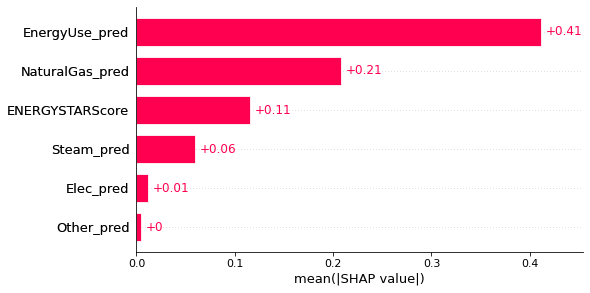

In [62]:
explainer = shap.Explainer(eln_random.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

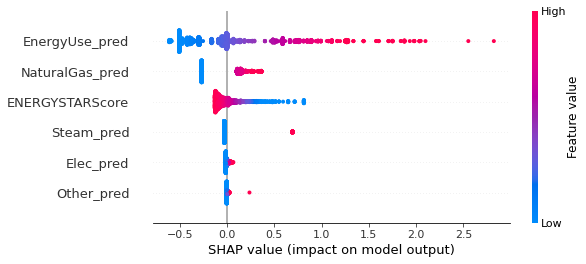

In [63]:
shap.summary_plot(shap_values, feature_names=features_name)

In [64]:
eln_df = pd.DataFrame(data = predictions)
eln_df['True_values'] = y_test
eln_df.columns = ['predictions', 'True_values']
eln_df['Residus'] = eln_df['predictions'] - eln_df['True_values']

In [65]:
eln_df = eln_df.sort_values('predictions')
eln_df = eln_df.reset_index(drop=True)

No handles with labels found to put in legend.


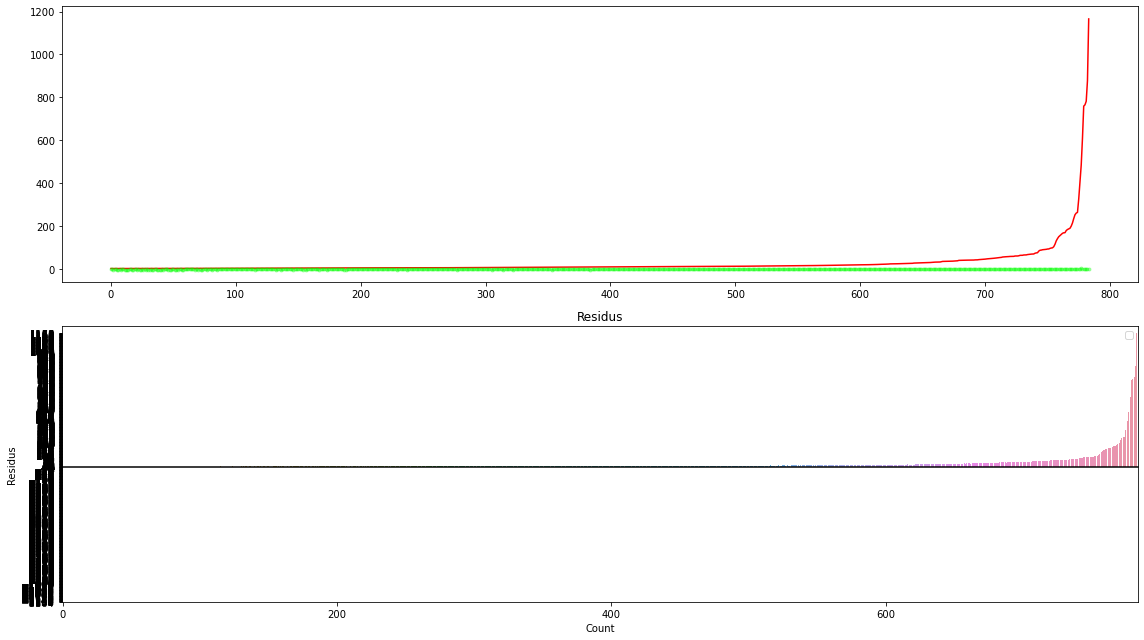

In [66]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(eln_df.index.to_list(), eln_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(eln_df.index.to_list(), eln_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')
axs[0].set_title("Représentation grpahique de la régression")
axs[0].set(xlabel='Count', ylabel='Valeur')

sns.barplot(x=eln_df.index.to_list(), y=eln_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(eln_df.index.to_list()), max(eln_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(eln_df['Residus']),0)-1, round(max(eln_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

### [b. XGBoost](#sommaire)<a class="anchor" id="8"></a>

In [67]:
xgb1 = XGBRegressor(booster = 'gbtree')
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,.02,.03, 0.05, .07], #so called `eta` value
              'max_depth': [2,3,4,5],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [400]}

xgb_grid = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        verbose=2,
                        n_iter = 200,
                        n_jobs = -1)

In [68]:
start = timer()
xgb_grid.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
The time of execution of above program is :  0:00:22.250348


In [69]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.6164697386468705
{'subsample': 0.7, 'objective': 'reg:squarederror', 'nthread': 4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}


In [70]:
best_random = xgb_grid.best_estimator_
random_accuracy_test = xgb_grid.score(X_test, y_test)
random_accuracy_train = xgb_grid.score(X_train, y_train)

In [71]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.7204595529696558
Score test : 0.6052941376979335


In [72]:
# Make predictions and determine the error

predictions = (np.exp(scaler_y.inverse_transform(xgb_grid.predict(X_train)))-1)
errors = abs((np.exp(scaler_y.inverse_transform(y_train))-1) - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs(((np.exp(scaler_y.inverse_transform(y_train))-1) - predictions) / (np.exp(scaler_y.inverse_transform(y_train))-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_train))-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_train))-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = (np.exp(scaler_y.inverse_transform(xgb_grid.predict(X_test)))-1)
errors = abs((np.exp(scaler_y.inverse_transform(y_test))-1) - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs(((np.exp(scaler_y.inverse_transform(y_test))-1) - predictions) / (np.exp(scaler_y.inverse_transform(y_test))-1)))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_test))-1), predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error((np.exp(scaler_y.inverse_transform(y_test))-1), predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

-- Train score --
Mean Absolute Deviation: 155.47
MAPE: 6.37 %.
MSE :  63323.65
RMSE :  251.64
Accuracy: 93.63 %.
-- Test score --
Mean Absolute Deviation: 125.55
MAPE: 4.7 %.
MSE :  330065.57
RMSE :  574.51
Accuracy: 95.3 %.


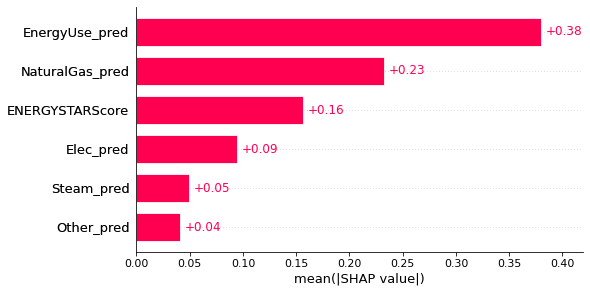

In [73]:
explainer = shap.TreeExplainer(xgb_grid.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

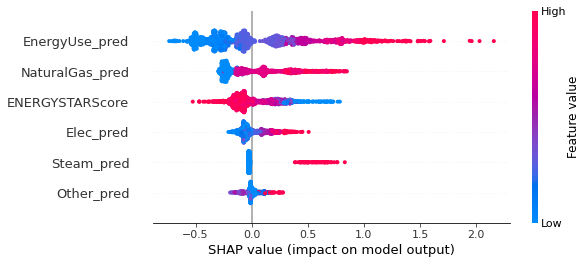

In [74]:
shap.summary_plot(shap_values, feature_names=features_name)

In [75]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(features_name, round(importance, 2)) for features_name, importance in zip(features_name, importances)]
# Sort the feature importances by most important firstperf_model['XGBoost Regressor'] = mape
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: EnergyUse_pred       Importance: 0.4399999976158142
Variable: NaturalGas_pred      Importance: 0.15000000596046448
Variable: Steam_pred           Importance: 0.14000000059604645
Variable: Elec_pred            Importance: 0.12999999523162842
Variable: ENERGYSTARScore      Importance: 0.07999999821186066
Variable: Other_pred           Importance: 0.07000000029802322


In [76]:
xgb_df = pd.DataFrame(data = (scaler_y.inverse_transform(xgb_grid.predict(X_test))))
xgb_df['True_values'] = (scaler_y.inverse_transform(y_test))
xgb_df.columns = ['predictions', 'True_values']
xgb_df['Residus'] = xgb_df['predictions'] - xgb_df['True_values']

In [77]:
xgb_df = xgb_df.sort_values('predictions')
xgb_df = xgb_df.reset_index(drop=True)

No handles with labels found to put in legend.


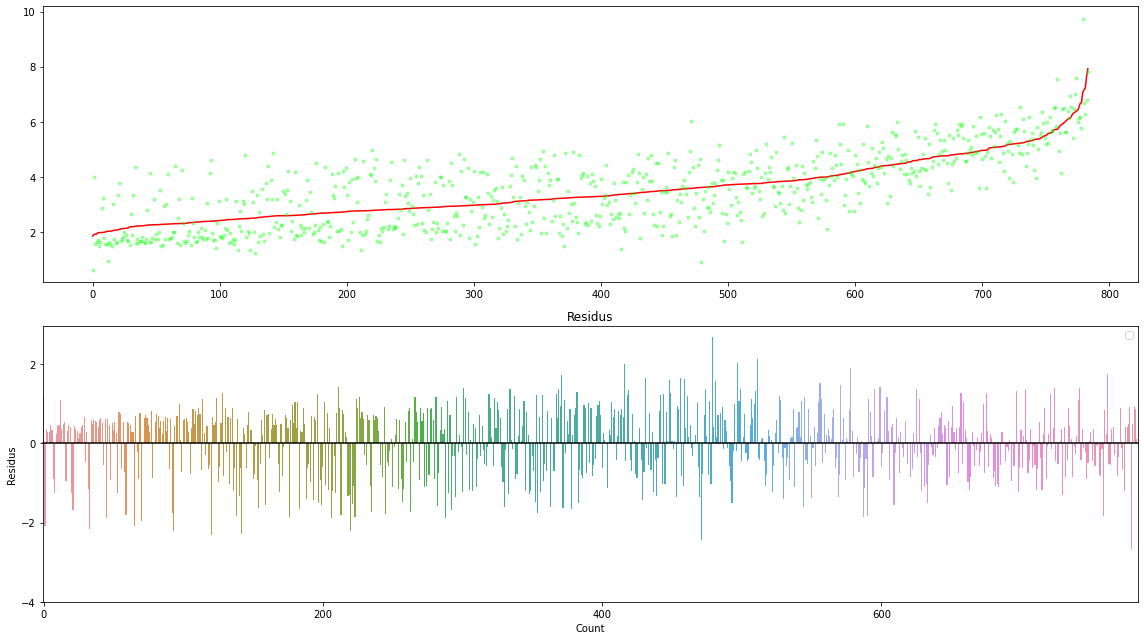

In [78]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(xgb_df.index.to_list(), xgb_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(xgb_df.index.to_list(), xgb_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')
axs[0].set_title("Représentation grpahique de la régression")
axs[0].set(xlabel='Count', ylabel='Valeur')

sns.barplot(x=xgb_df.index.to_list(), y=xgb_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(xgb_df.index.to_list()), max(xgb_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(xgb_df['Residus']),0)-1, round(max(xgb_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

## [CONCLUSION](#sommaire)<a class="anchor" id="9"></a>

<ul>
<li>Malgré un jeu de données ayant nécessité un nettoyage important, nous avons réussi à partir de données basique de bâtiment à prédire leur consommation énergétique</li>
<li>Pour gérer un nombre important de valeur nulle pour effectuer des prédictions il semble nécessaire de passer par une étape de classification préalable</li>
<li>La mission principale de prédiction des émissions de CO2 est possible via des prédictions sur les consommations énergétique, cependant nous n’arrivons pas à expliquer toute la variance supposant qu’il nous manque des variables, même si l’EnergyStarScore permet de pallier en partie à ce manque</li>
</ul>